### Library Import
코드를 실행하기 위한 모든 라이브러리들 import 과정

In [192]:
import tensorflow as tf
import datetime
import os
import operator
import shutil

from tensorflow.keras import backend as K
from tensorflow.keras import layers as L
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### Environment Variables
환경변수들

In [210]:
# resize할 크기
image_size = 36

# 한개의 element당 생성할 data 개수
data_size = 128

# data 경로
data_path = os.getcwd() + '/../data/'

# element들을 저장할 경로
element_path = data_path + 'alphebet/'

# example이 존재하는 경로
example_path = data_path + 'ex/'

# checkpoint 경로
model_path = './ckpt.h5'

### Create Folder
폴더를 생성해주는 함수

In [211]:
def create_folder(directory):
      if not os.path.exists(directory):
          os.makedirs(directory)
          return True
      return False

create_folder(element_path)
elements = os.listdir(example_path)
elements.sort()

print(tf.__version__)
print(os.getcwd())
print(data_path)
print(elements)

2.12.0
/Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code
/Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/
['a.png', 'b.png', 'c.png', 'd.png', 'e.png', 'f.png', 'g.png', 'h.png', 'i.png', 'j.png', 'k.png', 'l.png', 'm.png', 'n.png', 'o.png', 'p.png', 'q.png', 'r.png', 's.png', 't.png', 'u.png', 'v.png', 'w.png', 'x.png', 'y.png', 'z.png', 'zz.png']


### 데이터 늘리기
약간의 위치변화 혹은 회전을 통한 데이터 늘리는 과정

In [213]:
datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.15,
        height_shift_range=0.15,
        shear_range=0.1,
        zoom_range=0.1,
        fill_mode='constant',
        cval=255)


for i in elements:
    element = i.split('.')[0]

    # 폴더가 존재할 경우 파일 생성X
    if not create_folder(element_path + element):
       continue
    
    # 에시 파일읽기
    image = load_img(example_path + i)
    x = img_to_array(image)                 # image to array
    x = x.reshape((1,) + x.shape)           # reshape array
    
    if i == 'zz.png':
      for _ in range(10):
        path = element_path + element
        print(_, i, path)
        shutil.copy(example_path + i,
                    path + '/' + element + str(_)+'.jpg')
    else:  
      i = 0

      # save image
      for batch in datagen.flow(x, batch_size=1,
                                save_to_dir=element_path + element, 
                                save_prefix=element, 
                                save_format='jpg'):
          i += 1
          if i > (data_size / 4) * 5:
              break

0 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
1 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
2 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
3 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
4 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
5 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
6 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
7 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
8 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz
9 zz.png /Users/naburang/Desktop/Metal/tensorflow_venv.nosync/code/../data/alphebet/zz


### Load Data

In [214]:
def load_data(size):
    # data reader
    datagen = ImageDataGenerator(rotation_range=10,
                                 shear_range=5,
                                 validation_split=0.2)
    
    # train data
    train_generator = datagen.flow_from_directory(element_path,
                                                  target_size=(size,size),
                                                  subset='training')
    
    # validation data
    val_generator = datagen.flow_from_directory(element_path,
                                                target_size=(size,size),
                                                subset='validation')
    return train_generator, val_generator

### Make Model

In [225]:
def make_model(train, val, class_count, size = 36):
    K.clear_session()

    model_ckpt = ModelCheckpoint(model_path, save_best_only=True)
    reduce_lr = ReduceLROnPlateau(patience=8, verbose=1)
    early_stop = EarlyStopping(patience=20, verbose=2)

    entry = L.Input(shape=(size,size,3))
    x = L.SeparableConv2D(64,(3,3),activation='relu',padding ='same')(entry)
    x = L.MaxPooling2D((2,2))(x)

    x = L.SeparableConv2D(128,(3,3),activation='relu',padding ='same')(x)
    x = L.MaxPooling2D((2,2))(x)

    x = L.SeparableConv2D(256,(2,2),activation='relu',padding ='same')(x)
    x = L.GlobalMaxPooling2D()(x)

    x = L.Dense(256)(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(64,kernel_regularizer=l2(2e-4))(x)
    x = L.LeakyReLU()(x)
    x = L.Dense(class_count,activation='softmax')(x)

    model = Model(entry,x)
    model.compile(loss='categorical_crossentropy', 
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(train,
                        validation_data=val,
                        epochs=999,
                        batch_size=128,
                        callbacks=[model_ckpt, reduce_lr, early_stop],
                        verbose=1)
    return history

### Show Losses
학습 과정에서의 loss 그래프 출력

In [226]:
def show_losses(hist):
    _, loss_ax = plt.subplots(figsize=(10, 5))
    acc_ax = loss_ax.twinx()
    
    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    acc_ax.set_ylabel('accuray')
    loss_ax.legend(loc='upper left')
    acc_ax.legend(loc='lower left')

### Divide Image
이미지 쪼개기

In [227]:
def divide_image(img_name):
    # open image
    image = Image.open(data_path + img_name)
    
    # image width, height 구학기
    width, height = image.size[0], image.size[1]

    # 총 글자 길이 구하기
    length = int(width / height)

    # 폴더 생성
    create_folder(data_path + 'tmp/')
    
    for i in range(length):
        # 범위 지정
        area = (0 + i * height, 0,
                width / length * (i + 1), height)
        
        path = data_path + 'tmp/' + str(i) + '/data/'
        create_folder(path)
        cropped_img = image.crop(area)
        cropped_img.save(path + str(i) + '.png')        # 쪼갠 이미지 저장

    return length

### Remove Temporary Images
임시로 생성된 이미지 제거

In [228]:
def remove_tmp_imgs():
    try:
        shutil.rmtree(data_path + 'tmp')
    except:
        print('Warning: failed to delete temporary splited images')

### Model Train

Found 3338 images belonging to 27 classes.
Found 824 images belonging to 27 classes.
Could not find checkpoint, creating new model
Epoch 1/999


2023-06-02 22:07:40.444163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:07:42.589749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - ETA: 0s - loss: 3.2832 - accuracy: 0.0521

2023-06-02 22:08:01.414699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:08:01.678924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


105/105 [==============================] - 23s 176ms/step - loss: 3.2832 - accuracy: 0.0521 - val_loss: 3.0513 - val_accuracy: 0.0825 - lr: 0.0010
Epoch 2/999
105/105 [==============================] - 16s 155ms/step - loss: 2.4127 - accuracy: 0.1911 - val_loss: 1.8786 - val_accuracy: 0.3337 - lr: 0.0010
Epoch 3/999
105/105 [==============================] - 17s 161ms/step - loss: 1.4460 - accuracy: 0.4554 - val_loss: 0.9823 - val_accuracy: 0.6056 - lr: 0.0010
Epoch 4/999
105/105 [==============================] - 18s 169ms/step - loss: 0.7851 - accuracy: 0.7187 - val_loss: 0.5986 - val_accuracy: 0.7985 - lr: 0.0010
Epoch 5/999
105/105 [==============================] - 18s 168ms/step - loss: 0.3443 - accuracy: 0.8999 - val_loss: 0.4061 - val_accuracy: 0.8677 - lr: 0.0010
Epoch 6/999
105/105 [==============================] - 18s 172ms/step - loss: 0.2589 - accuracy: 0.9254 - val_loss: 0.1536 - val_accuracy: 0.9563 - lr: 0.0010
Epoch 7/999
105/105 [==============================] - 18s

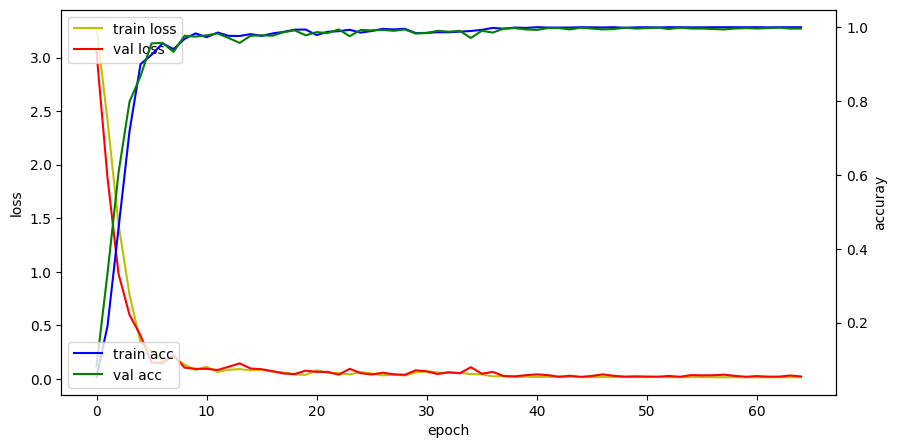

In [229]:
train_generator, val_generator = load_data(image_size)

with tf.device('/GPU:0'):
    try:
        load_model(model_path)
    except:
        print('Could not find checkpoint, creating new model')
        hist = make_model(train_generator, 
                          val_generator,
                          len(elements),
                          image_size)
        show_losses(hist)

### Integer To ASCII(Char)

In [230]:
def itoa(num):
    if num == 26:
        return  ' '
    else:
        num_tr = num+97
        return chr(num_tr)

### Predict

In [231]:
def predict(model, image_name):
    # 이미지 쪼개기
    length = divide_image(image_name)
    result = ''

    generator = ImageDataGenerator()
    image_path = data_path + 'tmp/'

    for i in range(length):
        # 쪼갠 이미지 불러오기
        data = generator.flow_from_directory(image_path + str(i), 
                                             target_size=(image_size, image_size))
    
        # Predict
        prediction = model.predict(data)[0]

        # 결과 가져오기
        predict_idx = np.argmax(prediction)
        predict_val = prediction[predict_idx]
        result += itoa(predict_idx)
        
        print('Best prediction:', predict_val, itoa(predict_idx))

    print('\nResult:', result)
    remove_tmp_imgs()

### Model 불러오기

In [232]:
model = load_model(model_path)
acc = model.evaluate(val_generator)[1]
print('Model accuracy: %.2f' % acc)

2023-06-02 22:26:07.077132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:26:07.323293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


26/26 [==============================] - 2s 47ms/step - loss: 0.0281 - accuracy: 0.9964
Model accuracy: 1.00


### Predict Image

In [233]:
predict(model, 'hell.png')

Found 1 images belonging to 1 classes.


2023-06-02 22:26:08.996970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:26:09.113279: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 377ms/step
Best prediction: 1.0 h
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 61ms/step
Best prediction: 1.0 e
Found 1 images belonging to 1 classes.


2023-06-02 22:26:09.460036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-06-02 22:26:09.610473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1/1 [==============================] - 0s 63ms/step
Best prediction: 0.99998236 l
Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 71ms/step
Best prediction: 0.99985325 l

Result: hell


2023-06-02 22:26:09.768016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
